In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import os
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier

#  Splitting Artists and Applying Label Binarizer

In [ ]:
# Loading Dataset
song_data = pd.read_csv("dataset.csv", sep = ',')

# Trimming Dataset
song_data = song_data[song_data['Genre'] != 'n-a']
song_data = song_data[song_data.iloc[:, 0].str.contains("Global") == True].reset_index(drop=True)

#Drop rows with nan values
allcols = ['Title', 'Artist','Genre_new','Explicit_false','Explicit_true','danceability','energy','key','loudness','mode','speechiness','acoustics','instrumentalness','liveliness','valence','tempo','duration_ms','time_signature','syuzhet_norm','bing_norm_negative','bing_norm_neutral','bing_norm_positive','afinn_norm','nrc_norm','n_words','anger_norm2','anticipation_norm2','disgust_norm2','fear_norm2','joy_norm2','sadness_norm2','surprise_norm2','trust_norm2','negative_norm2','positive_norm2','negative_bog_jr','positive_bog_jr','Negative_Bayes','Neutral_Bayes','Positive_Bayes','Celebrate','Desire','Explore','Fun','Hope','Love','Nostalgia','Thug','Popu_max','Top10_dummy','Top50_dummy']
song_data = song_data[allcols]
song_data = song_data.dropna()


### Code for preprocessing with splitting artists ###
# use regex on whole column to make DataFrame 
artists_before = song_data[['Artist']]
artists_new = artists_before.Artist.str.split(pat=' - ',expand=True)

# Create a list of lists containing the artist(s) for each song
artists_list = []
for i in range(artists_new.shape[0]):
    artists_list.append(list(filter(None, list(set(artists_new.iloc[i])))))

# Label Binarizer
mlb = preprocessing.MultiLabelBinarizer()
ALB = mlb.fit_transform(artists_list)

# DataFrame with Binarized columns, sorted by artist name
ALB_DF = pd.DataFrame(ALB, columns=["Artist_" + str(i) for i in mlb.classes_])
### Code for preprocessing with splitting artists ###


# Chosen Features (Can change based on feature selection experiments)
xcols = ['Explicit_false','Explicit_true','danceability','energy','key','loudness','mode','speechiness','acoustics','instrumentalness','liveliness','valence','tempo','duration_ms','time_signature','syuzhet_norm','bing_norm_negative','bing_norm_neutral','bing_norm_positive','afinn_norm','nrc_norm','n_words','anger_norm2','anticipation_norm2','disgust_norm2','fear_norm2','joy_norm2','sadness_norm2','surprise_norm2','trust_norm2','negative_norm2','positive_norm2','negative_bog_jr','positive_bog_jr','Negative_Bayes','Neutral_Bayes','Positive_Bayes','Celebrate','Desire','Explore','Fun','Hope','Love','Nostalgia','Thug','Popu_max','Top10_dummy','Top50_dummy']

X4 = song_data[xcols]

# Standard Scaler Preprocessing on chosen numerical features
normalized_X = X4.values
std_scalor = preprocessing.StandardScaler()
X_scaled = std_scalor.fit_transform(normalized_X)
normalized_X = pd.DataFrame(X_scaled, columns=xcols)

# Combining both DataFrames (Binarized Artists + Preprocessed numerical features)
XT = pd.concat([normalized_X.reset_index(drop=True), ALB_DF.reset_index(drop=True)], axis=1)

# Target Labels
y = song_data[['Genre_new']].reset_index(drop=True)

# Combining some genres into larger groups (Can add more here if necessary)
replace_dict = {
    'rap':'hip hop',
    'metal':'rock',
    'trap':'hip hop',
    'house': 'dance/electronic',
    'bolero':'else',
    'reggaeton':'else' #Use this reggaeton grouping in case of drop rows with nan values
}

ybetter = y['Genre_new'].replace(replace_dict)

YDF = pd.DataFrame(ybetter)

C:\Users\Bismarck\AppData\Local\Temp\ipykernel_7132\200972194.py:2: DtypeWarning: Columns (7,8,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  song_data = pd.read_csv("dataset.csv", sep = ',')


In [ ]:
print(XT.shape)
print(YDF.shape)
print(song_data.shape)
print(XT.isnull().values.any())
print(YDF.isnull().values.any())
print(song_data.isnull().values.any())

(3100, 1000)
(3100, 1)
(3100, 51)
False
False
False


In [ ]:
for col in xcols:
    if XT[col].isnull().values.any():
        print(col)

In [ ]:
YDF['Genre_new'].value_counts()

hip hop             1241
pop                 1155
dance/electronic     189
rock                 177
r&b/soul             125
boy band              63
k-pop                 42
else                  37
indie                 35
country               19
latin                  9
funk                   8
Name: Genre_new, dtype: int64

# Split dataset into train and test

In [ ]:
y=YDF
X_train, X_test, Y_train, Y_test = train_test_split(XT, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

(2480, 1000)
(620, 1000)


In [ ]:
Y_train['Genre_new'].value_counts()

hip hop             999
pop                 929
rock                147
dance/electronic    139
r&b/soul            100
boy band             47
k-pop                34
else                 31
indie                27
country              13
funk                  8
latin                 6
Name: Genre_new, dtype: int64

# ANOVA F measure

https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/ 

In [ ]:
%%time

num_features = []
features_f = []
svm1 = []
svm2 = []
xcols = np.array(xcols)

#Range needs to change depending on feature vector length 
for count in range(1,XT.shape[1],10):
    #print(count)
    clf_svm = LinearSVC(C=0.1,max_iter=100000000)
    cv = StratifiedKFold(5)
    
    test = SelectKBest(score_func=f_classif, k = count)
    X_F_measure = test.fit_transform(XT,y.values.ravel())
    X_F_measure = pd.DataFrame(X_F_measure, columns=test.get_feature_names_out())
    features_f.append(test.get_feature_names_out())
    X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_F_measure, y, test_size=0.2)
    
    clf_svm.fit(X_train2, Y_train2.values.ravel())
    svm1.append(cross_val_score(clf_svm, X_train2, Y_train2.values.ravel(), cv=cv, n_jobs=15).mean())
    svm2.append(clf_svm.score(X_test2, Y_test2.values.ravel()))
    
    num_features.append(count)

C:\Users\Bismarck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Bismarck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Bismarck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Bismarck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\s

CPU times: total: 1min 27s
Wall time: 4min 44s


In [ ]:
classifiers = ['Decision Trees','Random Forests','K nearest neighbors', 'Logistic Regression','SVM']
train_acc_F_measure = []
test_acc_F_measure = []
best_num_feats = []

# test_acc_F_measure.append(max(dt2))
# best_num_feats.append(num_features[dt2.index(max(dt2))])
# train_acc_F_measure.append(dt1[dt2.index(max(dt2))])

# test_acc_F_measure.append(max(rf2))
# best_num_feats.append(num_features[rf2.index(max(rf2))])
# train_acc_F_measure.append(rf1[rf2.index(max(rf2))])

# test_acc_F_measure.append(max(knn2))
# best_num_feats.append(num_features[knn2.index(max(knn2))])
# train_acc_F_measure.append(knn1[knn2.index(max(knn2))])

# test_acc_F_measure.append(max(lr2))
# best_num_feats.append(num_features[lr2.index(max(lr2))])
# train_acc_F_measure.append(lr1[lr2.index(max(lr2))])

test_acc_F_measure.append(max(svm2))
best_num_feats.append(num_features[svm2.index(max(svm2))])
train_acc_F_measure.append(svm1[svm2.index(max(svm2))])
#print(features_f[svm2.index(max(svm2))])

test_err_F = [(1-i) for i in test_acc_F_measure]
train_err_F = [(1-j) for j in train_acc_F_measure]

print(classifiers)
print(train_err_F)
print(test_err_F)
print(best_num_feats)

['Decision Trees', 'Random Forests', 'K nearest neighbors', 'Logistic Regression', 'SVM']
[0.14274193548387104]
[0.1064516129032258]
[791]


# SVC Fine Tuning

In [ ]:
best_features = features_f[svm2.index(max(svm2))]
X = XT[best_features]
Y = YDF
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
c_values = []
accuracies = []
c_value = 1e-8
alpha = 10
i = 0
while i < 15:
    bigC = c_value * (alpha**i)
    model = LinearSVC(C=bigC, multi_class="ovr", penalty="l2", max_iter = 3000)
    c_values.append(bigC)
    scores = cross_val_score(model, X, Y.values.ravel(), cv=5)
    average = sum(scores) / len(scores)
    accuracies.append(average)
    i = i+1

C:\Users\Bismarck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Bismarck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Bismarck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Bismarck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblin

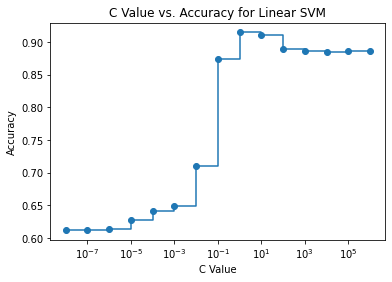

In [ ]:
#Plot the data on a graph
fix, ax = plt.subplots()
ax.set_xlabel("C Value")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs. C Value for Linear SVM")
ax.set_xscale('log')
ax.plot(c_values, accuracies, marker='o', label='Train', drawstyle="steps-post")
plt.show()

In [ ]:
c_values = []
accuracies = []
c_value = 1e-8
alpha = 10
i = 0
while i < 15:
    bigC = c_value * (alpha**i)
    model = LinearSVC(C=bigC, multi_class="ovr", penalty="l2", max_iter = 3000)
    c_values.append(bigC)
    scores = cross_val_score(model, XT, Y.values.ravel(), cv=5)
    average = sum(scores) / len(scores)
    accuracies.append(average)
    i = i+1

C:\Users\Bismarck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Bismarck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Bismarck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Bismarck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblin

In [ ]:
#Plot the data on a graph
fix, ax = plt.subplots()
ax.set_xlabel("C Value")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs. C Value for Linear SVM")
ax.set_xscale('log')
ax.plot(c_values, accuracies, marker='o', label='Train', drawstyle="steps-post")
plt.show()

NameError: ignored

# Finished Model

In [ ]:
model = LinearSVC(C=1, multi_class="ovr", penalty="l2", max_iter = 3000)
model.fit(X_train, y_train)
model.score(X_test, y_test)

C:\Users\Bismarck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bismarck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9096774193548387

In [ ]:
X = XT
Y = YDF
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
model.fit(X_train, y_train)
model.score(X_test, y_test)

C:\Users\Bismarck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Bismarck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9145161290322581

In [ ]:
%%time
#rfecv_clf = svm.SVC(C=0.1, kernel='linear')
rfecv_clf = LinearSVC(C=0.1,max_iter=100000000)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=20)
cv = StratifiedKFold(5)
rfecv = RFECV(estimator = rfecv_clf, step = 10, cv = cv, scoring='accuracy', n_jobs=15 )
rfetrain=rfecv.fit(X_train, y_train.values.ravel())
print('Optimal number of features :', rfecv.n_features_)

rfe = RFE(estimator=rfecv_clf, n_features_to_select=rfecv.n_features_, step=1)
rfe = rfe.fit(X_train, y_train.values.ravel())

rfe_X_train = X_train.loc[:, rfe.get_support()]
rfe_X_test = X_test.loc[:, rfe.get_support()]
print(rfe_X_train.shape)
print(rfe_X_test.shape)

Optimal number of features : 670
(2480, 670)
(620, 670)
CPU times: total: 3min 8s
Wall time: 4min 25s


In [ ]:
model = LinearSVC(C=1, multi_class="ovr", penalty="l2", max_iter = 10000)
model.fit(rfe_X_train, y_train.values.ravel())
model.score(rfe_X_test, y_test.values.ravel())

0.9145161290322581